In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt



#Load our Data

In [2]:
url = "https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")


# Dara Exploration

In [3]:
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [4]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2025-04-26,A,428587,317347
2025-04-27,U,329874,245932
2025-04-28,W,604201,393731


<Axes: xlabel='date'>

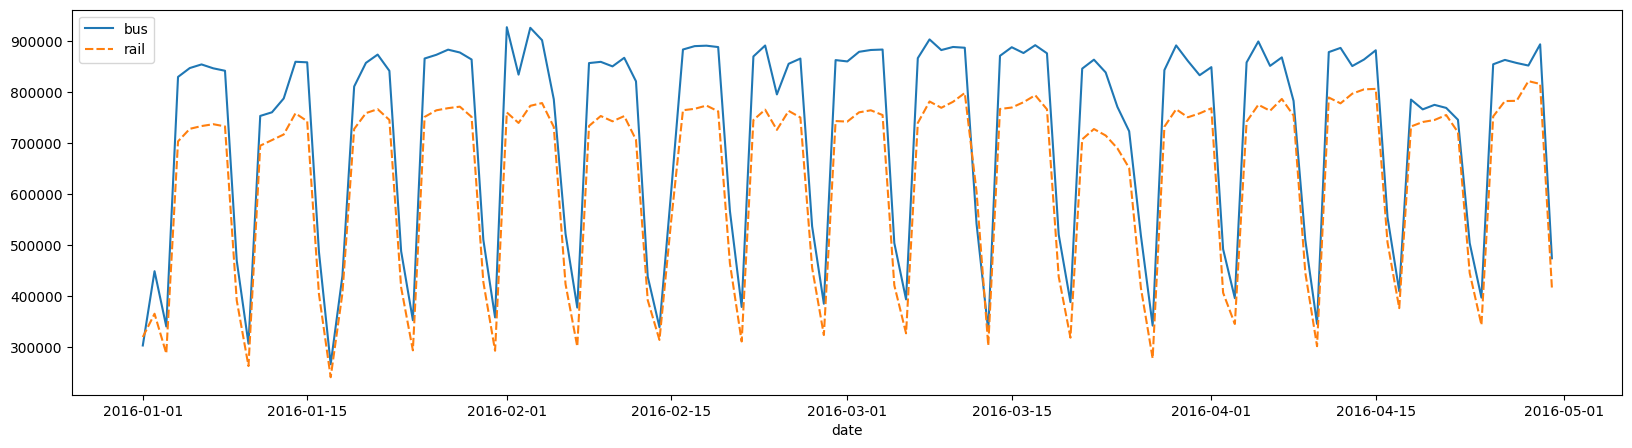

In [5]:
plt.figure(figsize=(20, 5))
sns.lineplot(df['2016-01':'2016-04'])

<Axes: xlabel='date'>

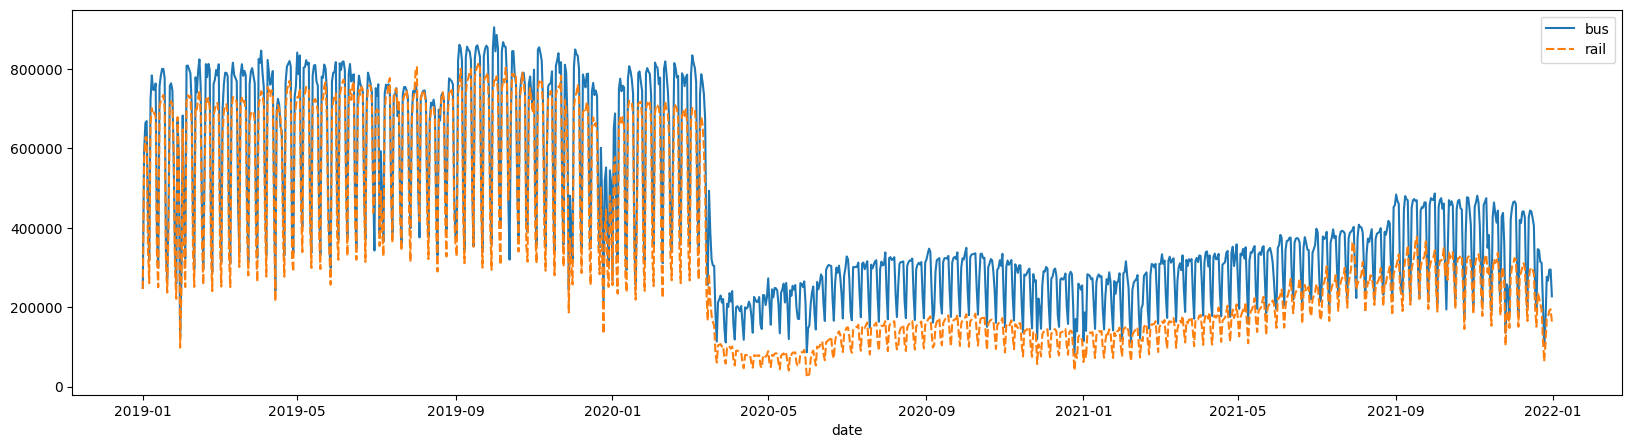

In [6]:
plt.figure(figsize=(20, 5))
sns.lineplot(df['2019':'2021'])

<Axes: xlabel='date'>

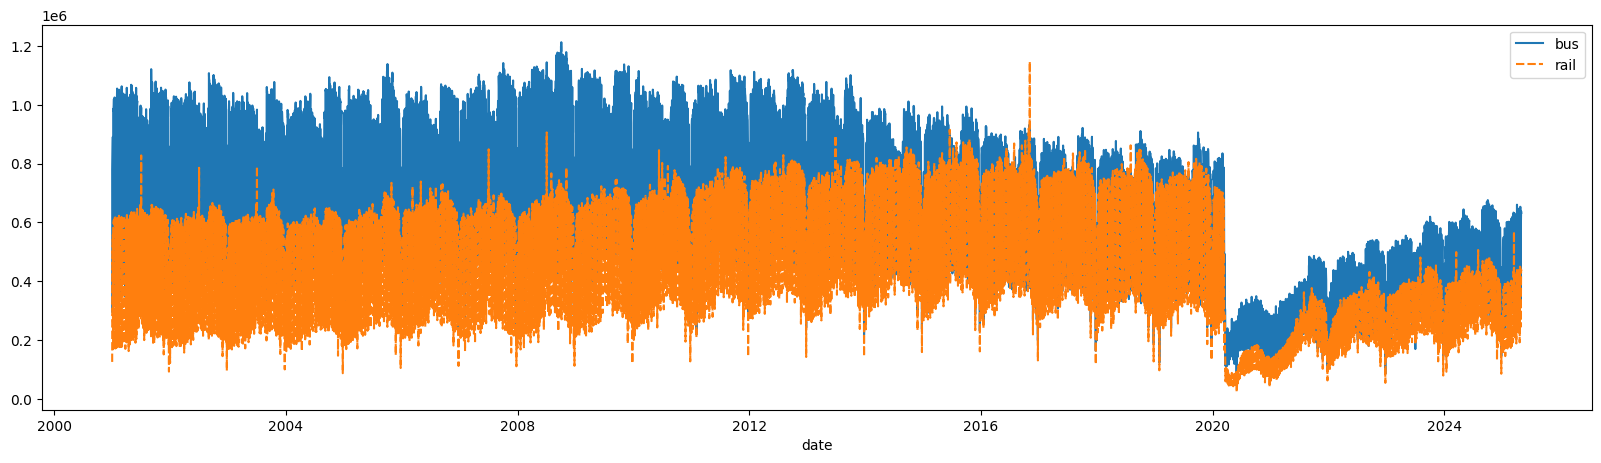

In [7]:
plt.figure(figsize=(20, 5))
sns.lineplot(df)

In [8]:
df['next_day_type']=df['day_type'].shift(-1)

In [9]:
df

,day_type,bus,rail,next_day_type
date,,,,
2001-01-01,U,297192,126455,W
2001-01-02,W,780827,501952,W
2001-01-03,W,824923,536432,W
2001-01-04,W,870021,550011,W
2001-01-05,W,890426,557917,A
...,...,...,...,...
2025-04-26,A,428587,317347,U
2025-04-27,U,329874,245932,W
2025-04-28,W,604201,393731,W


In [10]:
df[['A','U','W']]=pd.get_dummies(df['day_type'],dtype=int)
df[['Anext','Unext','Wnext']]=pd.get_dummies(df['next_day_type'],dtype=int)

In [11]:
df.drop(['day_type','next_day_type'],inplace=True,axis=1)

In [12]:
df[['bus','rail']]=df[['bus','rail']]/1e6

In [13]:
df

,bus,rail,A,U,W,Anext,Unext,Wnext
date,,,,,,,,
2001-01-01,0.297192,0.126455,0,1,0,0,0,1
2001-01-02,0.780827,0.501952,0,0,1,0,0,1
2001-01-03,0.824923,0.536432,0,0,1,0,0,1
2001-01-04,0.870021,0.550011,0,0,1,0,0,1
2001-01-05,0.890426,0.557917,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
2025-04-26,0.428587,0.317347,1,0,0,0,1,0
2025-04-27,0.329874,0.245932,0,1,0,0,0,1
2025-04-28,0.604201,0.393731,0,0,1,0,0,1


# Let's make our train, validation and test sets

In [14]:
train=df['2001':'2015']
valid=df['2016':'2019']
test=df['2023':]

In [15]:
len(train),len(valid),len(test)

(5478, 1461, 851)

In [58]:

train_ds=tf.keras.utils.timeseries_dataset_from_array(train,
                                                      sequence_length=14,
                                                      targets=train['rail'][14:],
                                                      batch_size=32,
                                                      shuffle=True)
valid_ds=tf.keras.utils.timeseries_dataset_from_array(valid,
                                                      sequence_length=14,
                                                      targets=valid['rail'][14:],
                                                      batch_size=32
                                                      )
test_ds=tf.keras.utils.timeseries_dataset_from_array(test,
                                                     sequence_length=14,
                                                     targets=test['rail'][14:],
                                                     batch_size=32
                                                     )

# Model_1

In [59]:
model_1=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14,8)),
    tf.keras.layers.LSTM(345,return_sequences=True),
    tf.keras.layers.LSTM(345,return_sequences=True),
    tf.keras.layers.GRU(345),
    tf.keras.layers.Dense(1)
])
model_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 14, 345)        │       488,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 14, 345)        │       953,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 345)            │       716,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           346 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,158,666 (8.23 MB)

 Trainable params: 2,158,666 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
def lr_schedule_exp(epoch):
  if epoch<50:
    return float(tf.exp(-epoch/10.)*0.01)/2
  else:
    return 0.0001/5
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model.keras',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

In [61]:
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['mae'])

In [62]:
history_1=model_1.fit(train_ds,
            epochs=100,
            validation_data=valid_ds,
            verbose=1,callbacks=[learning_rate_callback,checkpoint])

Epoch 1/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3858 - mae: 0.3858
Epoch 1: val_loss improved from inf to 0.04422, saving model to model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 85s 17ms/step - loss: 0.3829 - mae: 0.3829 - val_loss: 0.0442 - val_mae: 0.0442 - learning_rate: 0.0050
Epoch 2/100
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0414 - mae: 0.0414
Epoch 2: val_loss improved from 0.04422 to 0.04328, saving model to model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0413 - mae: 0.0413 - val_loss: 0.0433 - val_mae: 0.0433 - learning_rate: 0.0045
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0340 - mae: 0.0340
Epoch 3: val_loss improved from 0.04328 to 0.04293, saving model to model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0429 - val_mae: 0.0429 - learning_rate: 0.0041
Epoch 4/100
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0300 - mae: 0.0300
Epoch 4: val_loss improved from 0.0

<Axes: >

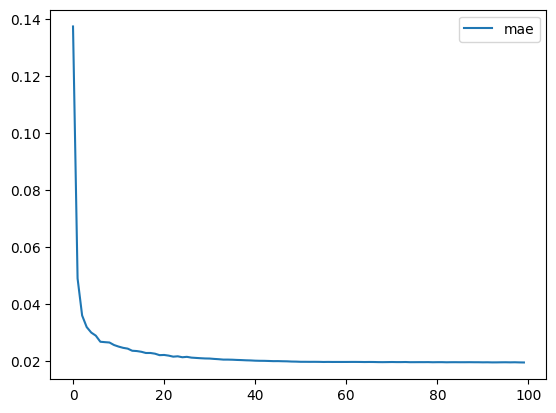

In [52]:
sns.lineplot(history_1.history['mae'],label='mae')


In [56]:
loss,mae=model_1.evaluate(valid_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0282 - mae: 0.0282


In [57]:
loss*1e6

27325.013652443886

In [77]:
pred=model_1.predict(valid_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [87]:
pred_df=pd.DataFrame(pred,index=valid.index[14:])

In [96]:
pred_df['2016':]

,0
date,
2016-01-15,0.765589
2016-01-16,0.443613
2016-01-17,0.304013
2016-01-18,0.697715
2016-01-19,0.587690
...,...
2019-12-27,0.494969
2019-12-28,0.315678
2019-12-29,0.260150


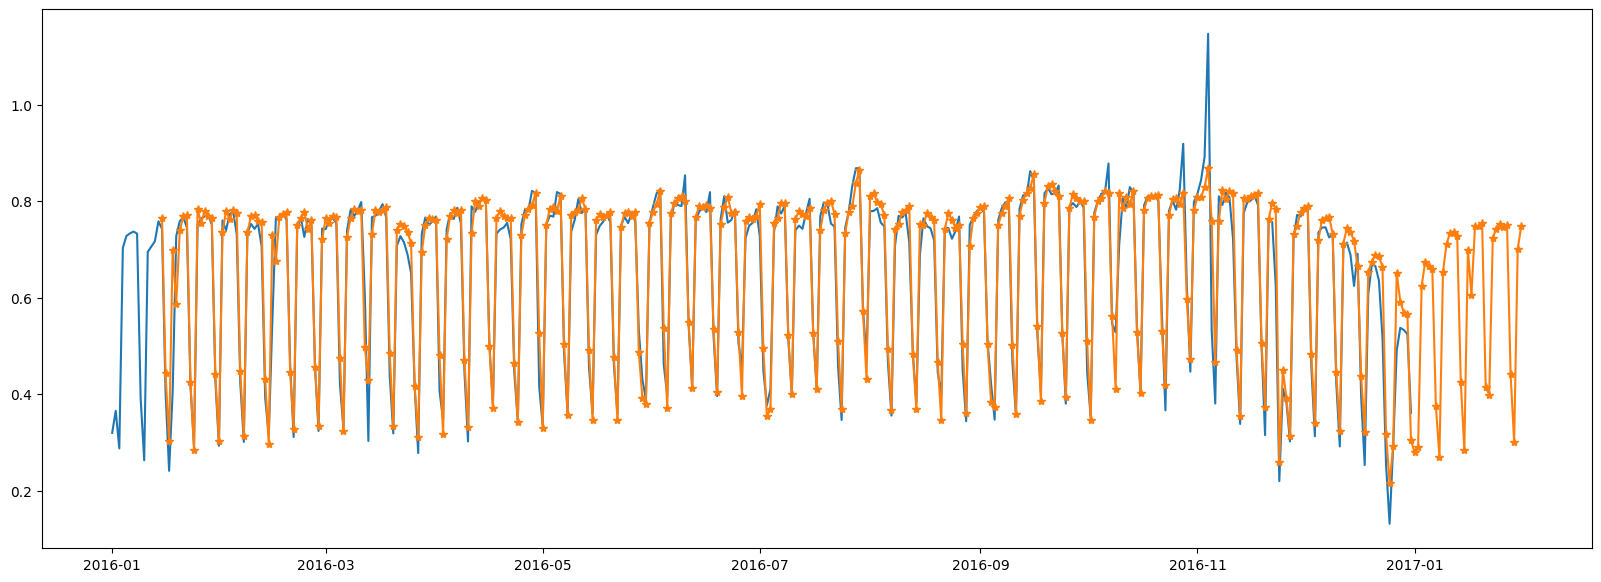

In [98]:
plt.figure(figsize=(20,7))
plt.plot(valid['rail']['2016'])
plt.plot(pred_df['2016-01':'2017-01'],marker='*')
